Storage deals are core to Filecoin. They are the [main mechanism by which clients and storage providers interact](https://filecoin.io/blog/posts/how-storage-and-retrieval-deals-work-on-filecoin/). 

Let's explore the data!

## Data Sources

Deals data is available from the on-chain state (via the [`StateMarketDeals`](https://lotus.filecoin.io/reference/lotus/state/#statemarketdeals) JSON-RPC method). The state doesn't reflect the historical deals, but should be enough to get a sense of things.

Alternatively you can use an [oracle like `fil-naive-marketwatch`](https://github.com/ribasushi/fil-naive-marketwatch), rely on APIs like [Spacescope](https://spacescope.io/) for aggregated data or reconstruct the deals from [Lily](https://lilium.sh/) CSV dumps, which can provide all deals in Filecoin history.

I'll rely on [Glif nodes](https://lotus.filecoin.io/lotus/developers/glif-nodes/) export of `StateMarketDeals` on S3 ([direct link](https://marketdeals.s3.amazonaws.com/StateMarketDeals.json.zst)).

In [1]:
import pandas as pd
import altair as alt

%load_ext sql
%config SqlMagic.displaycon = False
%sql --connection_arguments '{"read_only": true}'

## Market Deals State 

Some stats on the state of the market deals right now:

In [2]:
%%sql stats <<

select 
    sum(PieceSize) / 1024 ** 5 as total_pibs_in_active_deals,
    count(distinct DealID) as total_active_deals,
    count(distinct Provider) as total_active_providers,
    count(distinct Client) as total_active_clients,
    count(distinct PieceCID) as total_unique_pieces_in_active_deals,
from filecoin_state_market_deals
where SectorStartEpoch > 0 and SlashEpoch = -1

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [3]:
from IPython.display import Markdown


Markdown(
    f"""
- There are **{stats.DataFrame().values[0][0]:.2f} PIBs** in active deals.
- There are **{stats.DataFrame().values[0][1]:.0f} active deals**.
- There are **{stats.DataFrame().values[0][2]:.0f} active providers**.
- There are **{stats.DataFrame().values[0][3]:.0f} active clients**.
- There are **{stats.DataFrame().values[0][4]:.0f} unique pieces** in active deals.
"""
)



- There are **1134.41 PIBs** in active deals.
- There are **37637800 active deals**.
- There are **1531 active providers**.
- There are **1137 active clients**.
- There are **12230049 unique pieces** in active deals.


In [4]:
%%sql deals <<

select
    date_trunc('day', to_timestamp(SectorStartEpoch * 30::BIGINT + 1598306400)) as sector_start_at,
    count(distinct DealID) as total_active_deals,
    count(distinct Provider) as total_active_providers,
    count(distinct Client) as total_active_clients,
    sum(PieceSize) / 1024 ** 5 as total_pibs_in_active_deals,
from filecoin_state_market_deals
where SectorStartEpoch > 0 and SlashEpoch = -1
group by 1

In [5]:
deals = deals.DataFrame()
deals["sector_start_at"] = pd.to_datetime(deals["sector_start_at"])


In [6]:
deals["sector_start_at"] = pd.to_datetime(deals["sector_start_at"])


Over time, these metrics have been increasing:

In [7]:
# | column: screen-inset
# | layout-ncol: 3

c1 = (
    alt.Chart(deals)
    .mark_area()
    .encode(
        x=alt.X("sector_start_at:T", title="Sector Start At"),
        y=alt.Y("total_active_deals:Q", title="Total Active Deals"),
        tooltip=[
            alt.Tooltip("sector_start_at:T", title="Sector Start At"),
            alt.Tooltip("total_active_deals:Q", title="Total Active Deals"),
            alt.Tooltip("total_active_providers:Q", title="Total Active Providers"),
            alt.Tooltip("total_active_clients:Q", title="Total Active Clients"),
            alt.Tooltip(
                "total_pibs_in_active_deals:Q", title="Total PIBs in Active Deals"
            ),
        ],
    )
    .properties(width="container", height=400)
)

c2 = (
    alt.Chart(deals)
    .mark_area()
    .encode(
        x=alt.X("sector_start_at:T", title="Sector Start At"),
        y=alt.Y(
            "total_pibs_in_active_deals:Q", title="Total Size of Active Deals (PIBs)"
        ),
        tooltip=[
            alt.Tooltip("sector_start_at:T", title="Sector Start At"),
            alt.Tooltip("total_active_deals:Q", title="Total Active Deals"),
            alt.Tooltip("total_active_providers:Q", title="Total Active Providers"),
            alt.Tooltip("total_active_clients:Q", title="Total Active Clients"),
            alt.Tooltip(
                "total_pibs_in_active_deals:Q", title="Total PIBs in Active Deals"
            ),
        ],
    )
    .properties(width="container", height=400)
)

c3 = (
    alt.Chart(deals)
    .mark_area()
    .encode(
        x=alt.X("sector_start_at:T", title="Sector Start At"),
        y=alt.Y("total_active_providers:Q", title="Total Active Providers"),
        tooltip=[
            alt.Tooltip("sector_start_at:T", title="Sector Start At"),
            alt.Tooltip("total_active_deals:Q", title="Total Active Deals"),
            alt.Tooltip("total_active_providers:Q", title="Total Active Providers"),
            alt.Tooltip("total_active_clients:Q", title="Total Active Clients"),
            alt.Tooltip(
                "total_pibs_in_active_deals:Q", title="Total PIBs in Active Deals"
            ),
        ],
    )
    .properties(width="container", height=400)
)

c1.display()
c2.display()
c3.display()


alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

### Sector Start Lag

There is a natural lag between the time a deal is scheduled and the time it actually starts.

In [8]:
%%sql sector_start_lag <<

select 
    DealID,
    StartEpoch,
    SectorStartEpoch,
    StartEpoch - SectorStartEpoch as SectorStartLag,
from filecoin_state_market_deals
where SectorStartEpoch > 0

In [9]:
sector_start_lag = sector_start_lag.DataFrame()


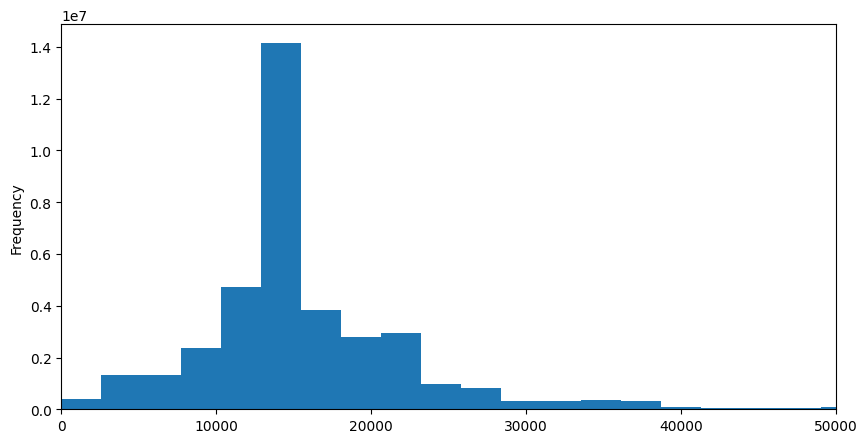

In [10]:
_ = sector_start_lag["SectorStartLag"].plot.hist(
    bins=100, xlim=(0, 50000), figsize=(10, 5)
)


## Replication Factor

Some pieces can have multiple copies across deals. This is the distribution across deals:

In [11]:
%%sql copies <<

select
    PieceCID."/" as piece_id,
    count(*) as copies
from filecoin_state_market_deals
where 1=1
    and SectorStartEpoch != -1
    and SlashEpoch = -1
group by piece_id
order by copies desc

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [13]:
copies = copies.DataFrame()


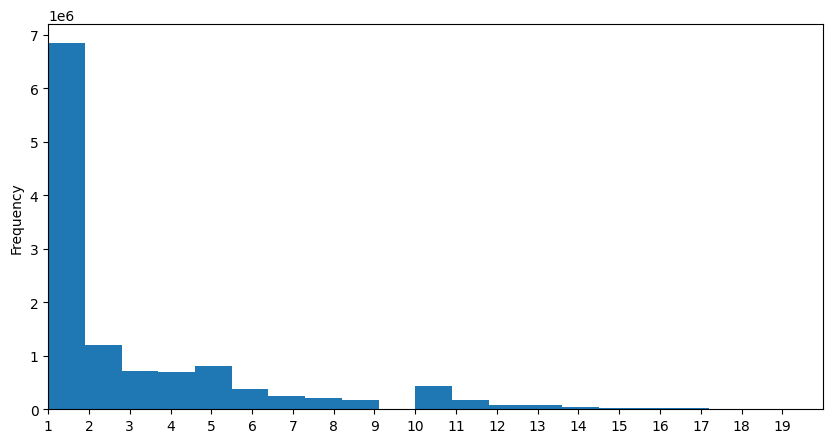

In [14]:
_ = copies[copies["copies"] < 20]["copies"].plot.hist(
    bins=20,
    figsize=(10, 5),
    xlim=(1, 20),
    xticks=range(1, 20),
)


These are the most copied pieces:


In [15]:
%%sql 

select
    PieceCID."/" as piece_id,
    count(*) as copies
from filecoin_state_market_deals
where 1=1
    and SectorStartEpoch != -1
    and SlashEpoch = -1
group by piece_id
order by copies desc
limit 10

piece_id,copies
baga6ea4seaqof356aeq4mvurh43yir2z6j3wguczeke4dy4lngbb7fwrmfpjydy,10420
baga6ea4seaqnvexhndom5ipydpn42c3va2jhuepv4bc7rwrc33t3x7gqkn53ugi,8640
baga6ea4seaqma3d2foqh3obhlxca2z4emobsarysx5pyrygroakuyxyd7sjzmby,6518
baga6ea4seaqfecaafawnex4i4z3dlpv5ngaxp5sa5spgf77mz3s3lvfidqom2da,636
baga6ea4seaqootvvm3rolzm7o4cdbshrgs4ceoe5rdwi6j6q52gmmkgtppwiogq,631
baga6ea4seaqpc6o5flzyg2ujmzdoydpjzkctembxk6mrfa6td3dzfcptbed4qkq,618
baga6ea4seaqmjgc2dhqsggctzwx5i2msscsdc5v27lva2tvanmd4j2pq27n2yaq,606
baga6ea4seaqdpednuhl5eukv7ym7lnxg66k3qzf5tf33h5uovhrkvwmlrpg24fa,596
baga6ea4seaqgshsnocaigqcar5frhf4f5xfvprumbzjjci2xofktnef6utiuyoa,595
baga6ea4seaqdorw3mefmpaabi7tx7rxu7qxmqdxkpeyyqg3myiq72pwfk6qzedq,594


Some of these pieces have more than 10k copies... Which providers are storing them? From which clients?

In [16]:
%%sql

select distinct
    Client,
    Provider,
from filecoin_state_market_deals
where PieceCID."/" = 'baga6ea4seaqof356aeq4mvurh43yir2z6j3wguczeke4dy4lngbb7fwrmfpjydy'

Client,Provider
f01624861,f01781851
f01624861,f01716466
